# MINI Transformer


## Import Dependencies


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from music21 import chord, note, stream, clef, meter
from data_cleaning import Open
import os
import numpy as np


## Constants


## Setup Dataset


### Open MIDI files


In [19]:
files_array = []


def open_midi_files(dest_directory):
    for root, dirs, files in os.walk(dest_directory):
        for file in files:
            mid_file = os.path.join(root, file)
            midi_data = Open.open_midi(mid_file)

            prog_array = []
            for i, part in enumerate(midi_data.parts):
                
                el_array = []
                for element in part.recurse():
                    if isinstance(element, chord.Chord):
                        el_array.append([p.midi for p in element.pitches])
                if el_array:
                    prog_array.append(el_array)

            files_array.append(prog_array)


open_midi_files(os.path.join(os.getcwd(), "sample_rock_set"))

part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  2
part  3
part  4
part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  0
part  1
part  2
part  3
part  0
part  1
part  2
part  3
part  4
part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  2
part  0
part  1
part  2
part  3
part  4
part  5
part  6
part  0
part  1
part  2
part  3
part  4
part  5
part  0
part  1
part  2
part  3
part  4
part  5
part  6
part  7
part  8
part  9
part  10
part  0
part  1
part  2
part  3
part  4
part  5
part  6
part  7
part  8
part  9
part  10


In [3]:
files_array[0][0][:3]  # File, Progression, Chord


[[67, 62, 55, 50, 47, 43], [64, 59, 55, 50, 45, 40], [67, 62, 55, 50, 47, 43]]

In [3]:
# all_chords = []
# for _prog in concatenated_array:
#     chord_arr = []
#     for _note in _chord:
#         chord_arr.append(_note.pitch.ps)
#     all_chords.append(chord_arr)

flattened_list = [
    each_note
    for each_file in files_array
    for each_prog in each_file
    for each_chord in each_prog
    for each_note in each_chord
]
notes = sorted(set(flattened_list))
n_to_i = {s: i for i, s in enumerate(notes)}
n_to_i[128] = len(n_to_i)

i_to_n = {value: key for key, value in n_to_i.items()}

mn_to_nn = {n: note.Note(n) for n in range(128)}

vocab_size = len(i_to_n)

In [4]:
# max_num_progressions = int(np.percentile([len(x) for x in files_array], 90))
# max_num_chords = int(
#     np.percentile([len(_prog) for _f in files_array for _prog in _f], 90)
# )
# max_num_notes = int(
#     np.percentile(
#         [len(_chord) for _f in files_array for _prog in _f for _chord in _prog], 95
#     )
# )
max_num_progressions = max([len(x) for x in files_array])
max_num_chords = max([len(_prog) for _f in files_array for _prog in _f])
max_num_notes = max(
    [len(_chord) for _f in files_array for _prog in _f for _chord in _prog]
)


In [6]:
print(max_num_progressions)
print(max_num_chords)
print(max_num_notes)


7
551
8


In [5]:
padded_files_array = []
for file in files_array:
    temp_file = file + [[[128]]] * (max_num_progressions - len(file))
    padded_progressions_array = []

    for i, progression in enumerate(temp_file):
        padded_chords_array = []
        temp_progression = progression + [[128]] * (max_num_chords - len(progression))

        for _chord in temp_progression:
            temp_chord = _chord + [128] * (max_num_notes - len(_chord))
            padded_chords_array.append([n_to_i[n] for n in temp_chord])
        padded_progressions_array.append(padded_chords_array)

    padded_files_array.append(padded_progressions_array)

In [6]:
torchified_files = torch.tensor(padded_files_array)
torchified_files.shape


torch.Size([14, 7, 551, 8])

## Visualization


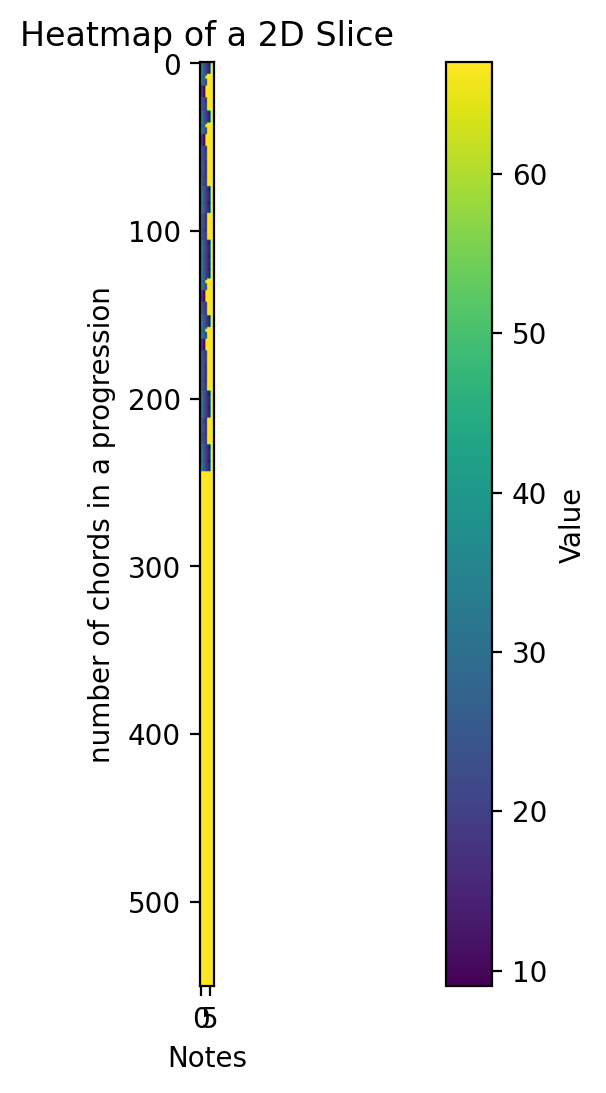

In [64]:
slice_2d = torchified_files[0, 0, :, :]  # This is a 2D slice (551, 8)

# Plot the slice as a heatmap
plt.figure(figsize=(30, 6))
plt.imshow(slice_2d, cmap="viridis")
plt.colorbar(label="Value")
plt.title("Heatmap of a 2D Slice")
plt.xlabel("Notes")
plt.ylabel("number of chords in a progression")
plt.show()

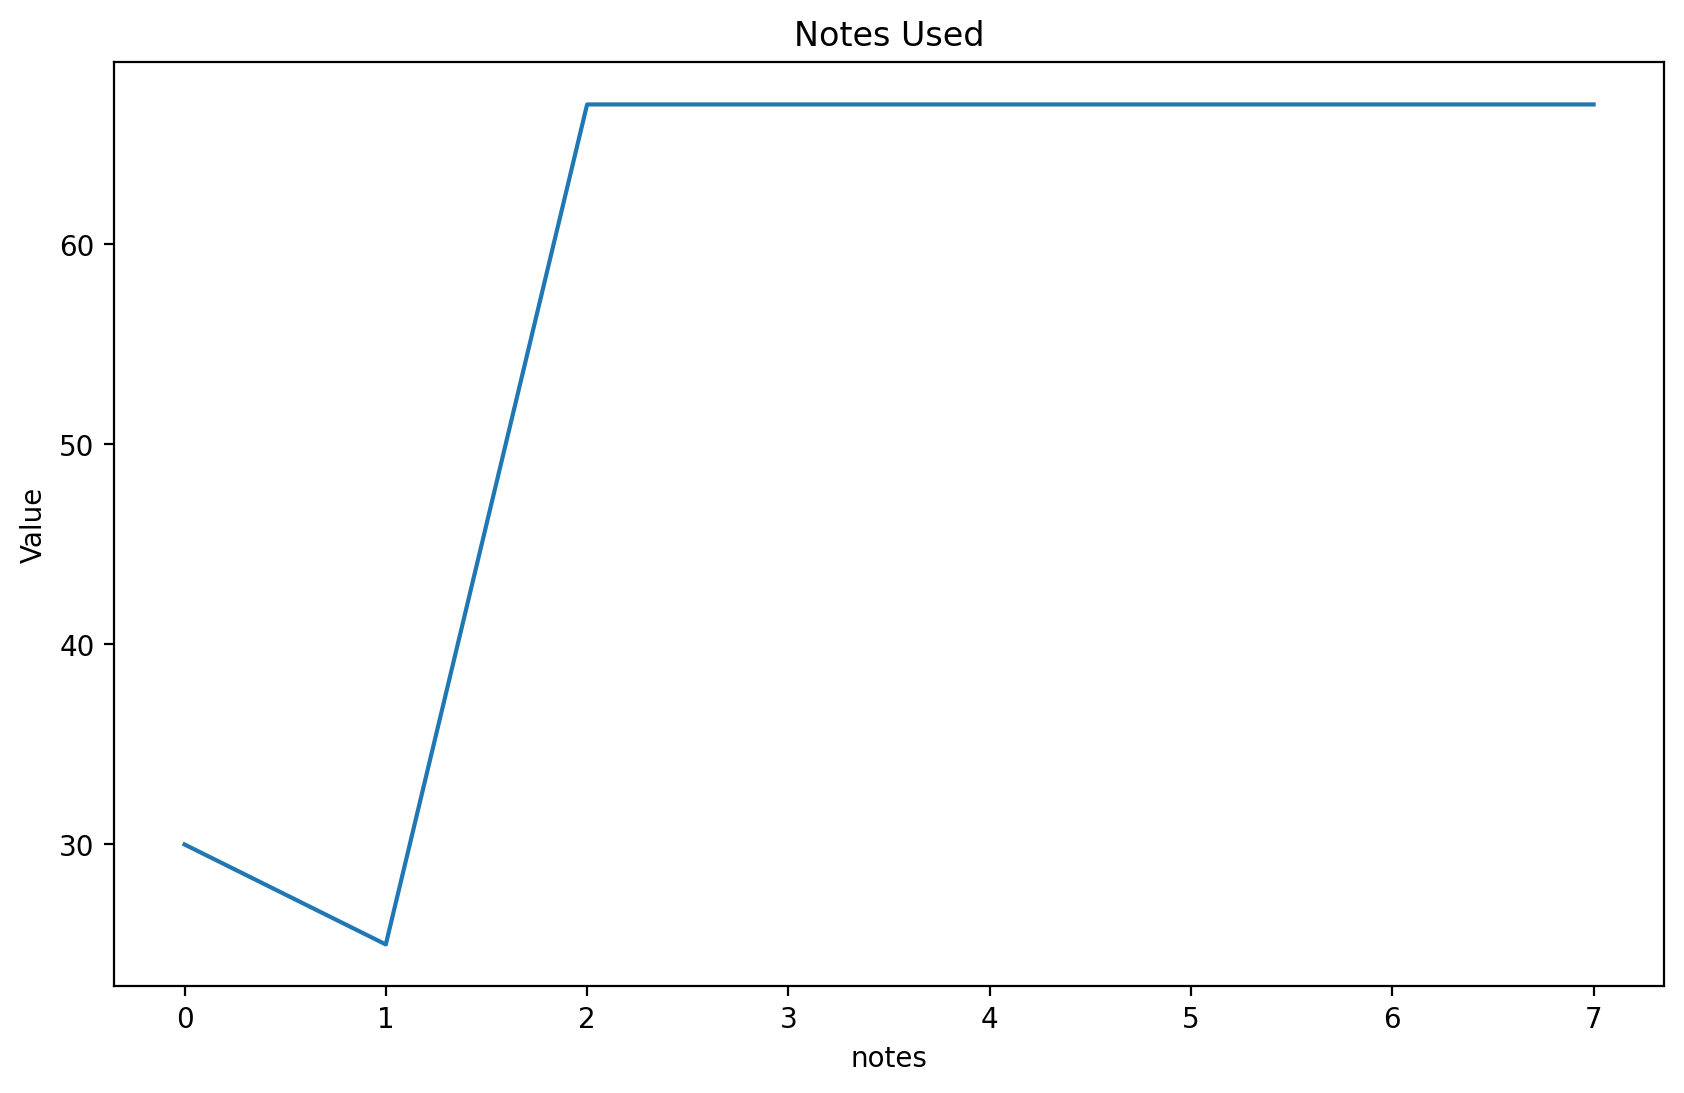

In [66]:
# Take a slice of the tensor
slice_1d = torchified_files[1, 0, 0, :]  # This is a 1D slice (8,)

# Plot the slice as a line plot
plt.figure(figsize=(10, 6))
plt.plot(slice_1d)
plt.title('Notes Used')
plt.xlabel('notes')
plt.ylabel('Value')
plt.show()

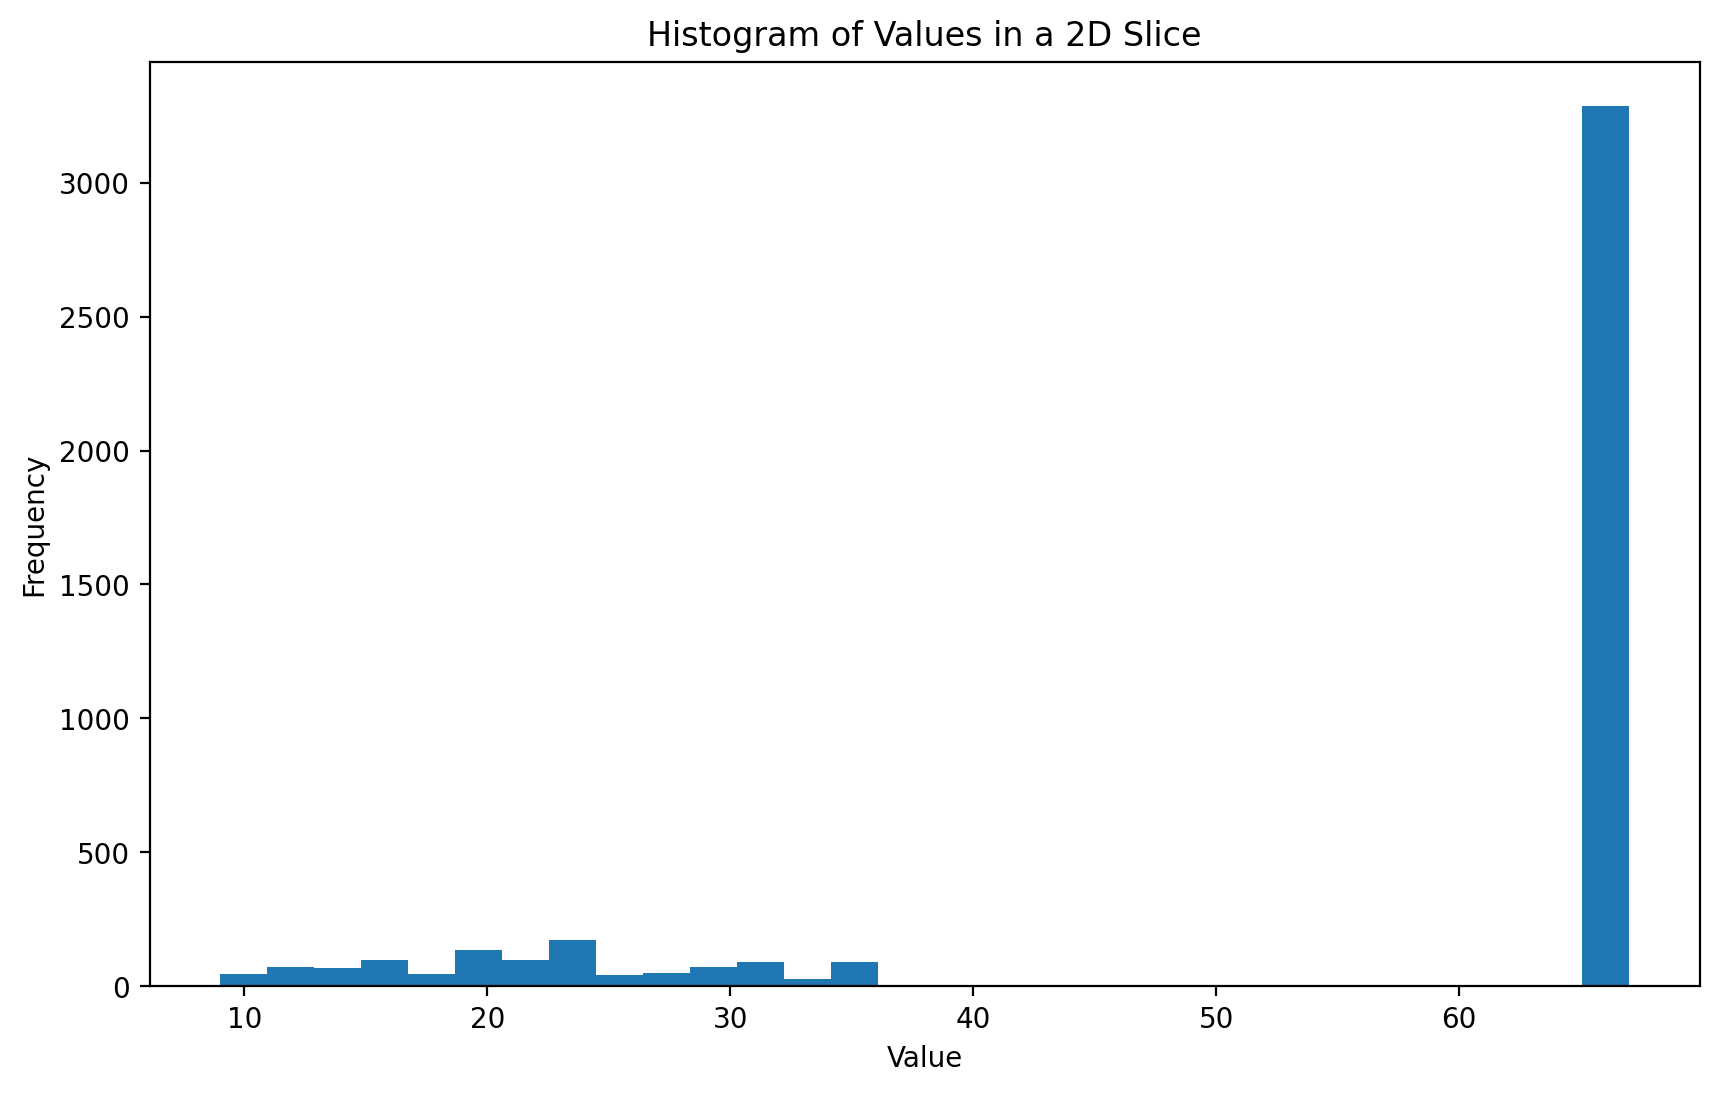

In [65]:
# Flatten the 2D slice to 1D
flat_slice = slice_2d.flatten()

# Plot a histogram of the values
plt.figure(figsize=(10, 6))
plt.hist(flat_slice, bins=30)
plt.title('Histogram of Values in a 2D Slice')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Batching


In [7]:
torchified_files = torchified_files.view(98, 551, 8)

In [10]:
n = int(0.9 * torchified_files.shape[1])  # first 90% will be train, rest val
train_data = torchified_files[:, :n]
val_data = torchified_files[:, n:]

### Set Length of context


In [17]:
batch_size = 4  # how many independent sequences will we process in parallel?
block_size = 8  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 32
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)


In [18]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### unused code


6


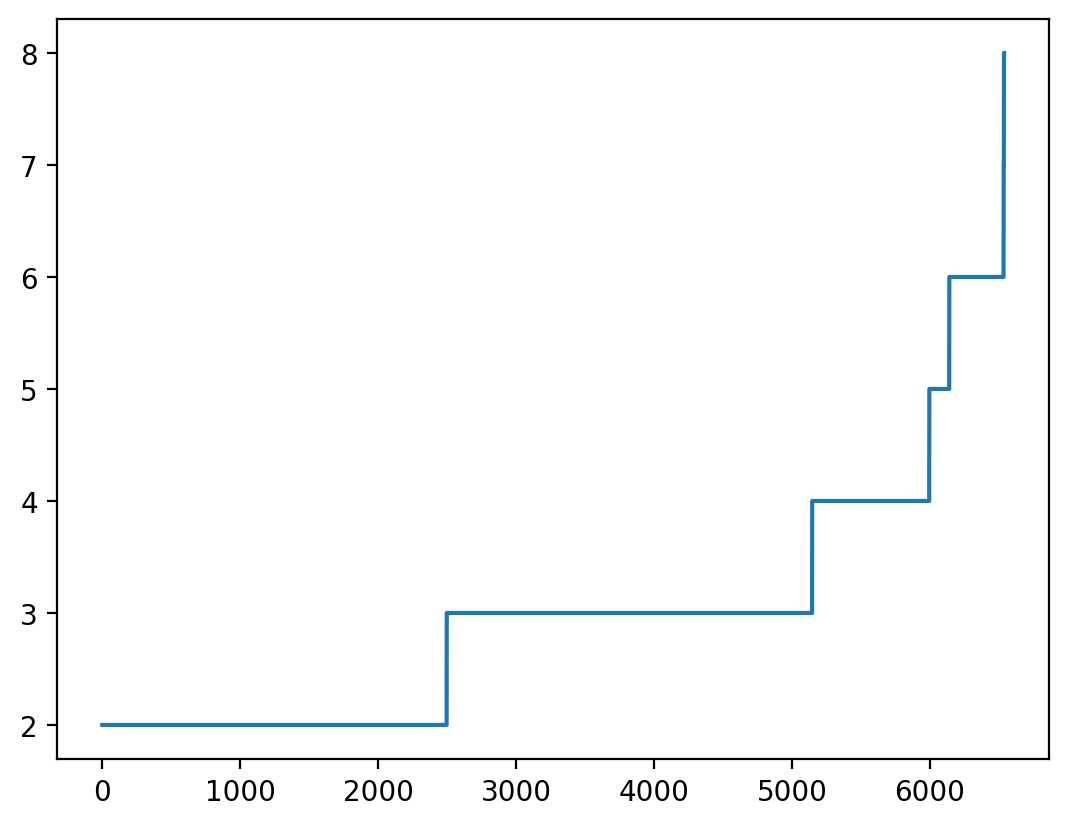

In [7]:
PERCENTILE = 97
percent = [len(x) for x in all_chords]
print(int(np.percentile([len(x) for x in all_chords], PERCENTILE)))
plt.plot(sorted(percent))

In [8]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_sequence_len = int(np.percentile([len(x) for x in all_chords], PERCENTILE))
ffn_hidden = 2048
num_layers = 5

PADDING_TOKEN = "_"
END_TOKEN = "."


## Tokenization


In [9]:
def is_valid_length(_chord, max_sequence_length):
    return len(list(_chord)) < (max_sequence_length - 1)


c_indices = []
for i, c in enumerate(all_chords):
    padded_c = c + [128] * (max_sequence_len - len(c))
    if is_valid_length(c, max_sequence_len):
        note_s = []
        for n in padded_c:
            note_s.append(n_to_i[n])
        c_indices.append(note_s)
padded_chords_tensor = torch.tensor(c_indices)


In [12]:
n = int(0.9 * len(padded_chords_tensor))  # first 90% will be train, rest val
train_data = padded_chords_tensor[:n]
val_data = padded_chords_tensor[n:]


In [11]:
padded_chords_tensor.shape


torch.Size([5995, 6])

## Maybe useful (but def not rn)


In [8]:
class ChordDataset(Dataset):
    def __init__(self, _all_chords):
        self._all_chords = _all_chords

    def __len__(self):
        return len(self._all_chords)

    def __getitem__(self, idx):
        return self._all_chords[idx]


In [9]:
dataSet = ChordDataset(padded_chords_tensor)


In [42]:
batch_size = 8
train_loader = DataLoader(dataSet, batch_size)
iterator = iter(train_loader)


In [43]:
all_batches = []
for batch_num, batch in enumerate(iterator):
    if batch_num == 3:
        break
    all_batches.append(batch)


all_batches = torch.stack(all_batches)

In [44]:
all_batches


tensor([[[35, 31, 26, 19, 67, 67],
         [33, 28, 24, 67, 67, 67],
         [33, 28, 24, 67, 67, 67],
         [35, 31, 26, 19, 67, 67],
         [35, 31, 26, 19, 67, 67],
         [35, 31, 26, 19, 67, 67],
         [35, 31, 26, 19, 67, 67],
         [21, 16,  9, 67, 67, 67]],

        [[21, 16,  9, 67, 67, 67],
         [21, 16,  9, 67, 67, 67],
         [21, 16,  9, 67, 67, 67],
         [21, 16,  9, 67, 67, 67],
         [21, 16,  9, 67, 67, 67],
         [21, 16,  9, 67, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [28, 24, 19, 14, 67, 67]],

        [[28, 24, 19, 14, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [29, 24, 21, 17, 67, 67],
         [35, 31, 26, 19, 67, 67],
         [33, 28, 24, 67, 67, 67]]])

In [45]:
one_hot_chords = F.one_hot(all_batches, num_classes=vocab_size)


In [47]:
one_hot_chords.shape  # batch, chords, chord size, vocab_size

torch.Size([3, 8, 6, 68])

## Data Loading


In [14]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [20]:
X, Y = get_batch("train")


In [21]:
X[0]


tensor([[29, 24, 21, 17, 67, 67],
        [29, 24, 21, 17, 67, 67],
        [29, 24, 21, 17, 67, 67],
        [35, 31, 26, 19, 67, 67],
        [33, 28, 24, 67, 67, 67],
        [33, 28, 24, 67, 67, 67],
        [35, 31, 26, 19, 67, 67],
        [35, 31, 26, 19, 67, 67]])